In [240]:
import numpy as np 
import matplotlib.pyplot as plt

In [241]:
angle,time,time_str = [],[],[]
with open('angle_time.csv', 'r') as f:
    line = f.readline() 
    while line: 
        a,ts = line.split(',')
        h,m = ts.split(':')
        t = int(h)*60 + int(m)

        angle.append(int(a))
        time.append(t)
        time_str.append(ts)

        line = f.readline() 

angles = np.array(angle)
times = np.array(time) 
times = times - times.min()
times = times / times.max()

In [ ]:
NIGHT = 102
END_SUNRISE = 85
DAY = 70

MAX_VAL = 255
VAL_MIN = 128
SAT_MIN = 80


HUE_POLY = 3
SAT_POLY = 2
VAL_POLY = 1.5

GREEN_START = (42+255)
GREEN_OFFSET = 85

STOP_HUE_CHANGE = (NIGHT - END_SUNRISE) / (NIGHT - DAY)

# Blue, Purple, Pink, Red
starting_hues = np.array([180,190,225,250])
# Blue, Pink, Orange, Gold
ending_hues = np.array([255+142, 229, 255+135, 255+40])

N_COLORS = starting_hues.shape[0]

# Convert from angle to percent
percents = (NIGHT-angles) / (NIGHT-DAY)
percents[percents < 0] = 0

In [243]:
import matplotlib.colors as mcolors

def draw_rectangle_gradient(ax, x1, y1, width, height, color1, color2, n=100):
    # Create an array of the linear gradient between the two colors
    gradient_colors = []
    for segment in np.linspace(0, width, n):
        interp_color = [(1 - segment / width) * color1[j] + (segment / width) * color2[j] for j in range(3)]
        if interp_color[0] > 1: 
            interp_color[0] -= 1

        gradient_colors.append(mcolors.hsv_to_rgb(interp_color))
    for i, color in enumerate(gradient_colors):
        ax.add_patch(plt.Rectangle((x1 + width/n * i, y1), width/n, height, color=color, linewidth=0, zorder=0))
    return ax

def green_filter(h): 
    filter_after = 0
    for h_ in h: 
        if h_ > GREEN_START:
            break 
        filter_after += 1 

    h[filter_after:] += GREEN_OFFSET

In [244]:
H=0; S=1; V=2
def update_leds(percent):  
    arr = [[0,0,0] for _ in range(N_COLORS)]

    s = ((255-SAT_MIN) * (1-pow(percent, SAT_POLY))) + SAT_MIN; 
    v = (MAX_VAL-VAL_MIN) * pow(percent, VAL_POLY)
    v = v+VAL_MIN if (percent != 0) else v
    
    percent = min(percent, STOP_HUE_CHANGE) / STOP_HUE_CHANGE; 
    for i in range(N_COLORS): 
        h = starting_hues[i] 
        offset = GREEN_OFFSET if ending_hues[i] > GREEN_START else 0
        hue_change = (ending_hues[i] - starting_hues[i]) - offset
        h += (pow(percent, HUE_POLY) * hue_change)
        #h += (pow(percent, HUE_POLY) * HUE_CHANGE)

        if (h > GREEN_START):
            h += GREEN_OFFSET

        arr[i][H] = h; 
        arr[i][S] = s; 
        arr[i][V] = 255; 

    arr = np.array(arr, dtype=np.float16)
    arr %= 256 
    arr /= 255
    return arr

[[  9.04 256.   256.  ]
 [ 19.08 256.   256.  ]
 [ 29.11 256.   256.  ]
 [ 39.16 256.   256.  ]]
[[141.5  80.3 256. ]
 [169.6  80.3 256. ]
 [189.8  80.3 256. ]
 [149.6  80.3 256. ]]


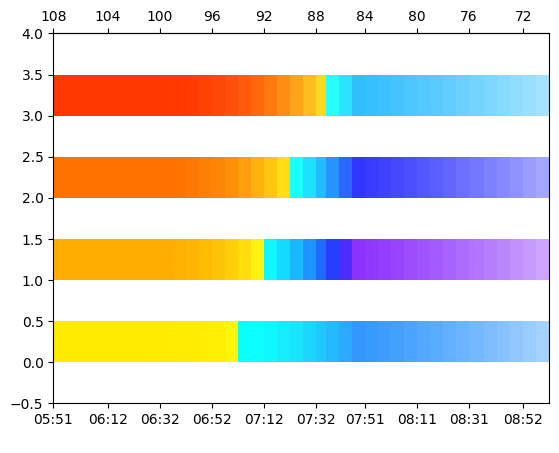

In [245]:
n = len(time_str)
ax = plt.axes()
for i in range(times.shape[0]-1): 
    c1 = update_leds(percents[i])
    c2 = update_leds(percents[i+1])

    if i == 0: 
        print(c1 * 256)

    for j in range(N_COLORS): 
        draw_rectangle_gradient(ax, times[i], 3-j, times[i+1]-times[i], 0.5, c1[j], c2[j], n=1)

print(c2 * 256)

ax.set_ylim(-0.5, len(starting_hues))
ax.set_xticks(times[::4], time_str[::4])
ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(times[::4], angles[::4])
plt.show()